## g:profiler enrichment analysis evaluation 

updated the gene name. 

1.  default setting pick the lowest p val when it pass both coverage and pval threshold as best term, then filter by coverage for both LLM and enrichment 
    
2. pick the smallest p val and remove the coverage requirment for both

    a. pick the smallest p, then add coverage requirement 

    b. pick the smallest p , then add JI requirement

3. pick best coverage among the ones passing both coverage and pval threshold, then filter by coverage 

4. use semantic similarity to find closest GO term as LLM name (in separate notebook), then use JI for picking best term and filtering 

    


In [6]:
LLM_score_thresh = 0.01 # only drop the ones LLM does not assign a name 
adj_pval_thresh = 0.05
JI_thresh = 0.05
coverage_thresh = 0.2

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.titlesize'] = 7

from utils.analyze_enrichment_utils import *
%load_ext autoreload
%autoreload 2

### Data files from other analyses:
 - inputfile: LLM analyzed + gProfiler enrichment analysis on updated gene symbols
 - LLM coverage analysis - used GPT-4 to review the analysis text to determine which genes met the criteria that they are "definite" supports, not conjecture.
 - Best matching GO terms to LLM names, used to estimate how many genes match the name, enabling the computation of a JI

In [8]:

import pandas as pd
from utils.analyze_enrichment_utils import cal_JI_coverage

group_col = ["Source", "GeneSetID", "GeneSetName", "GeneList"] # group by these columns in future steps

## input file: LLM analyzed + gProfiler enrichment
updated_name_llm_file = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF.tsv'
# Read the TSV file into a Pandas DataFrame
LLM_genes_DF = pd.read_csv(updated_name_llm_file, delimiter="\t")
# make sure intersection_size, term_size, query_size are integers
LLM_genes_DF['intersection_size'] = LLM_genes_DF['intersection_size'].apply(lambda x: int(x))
LLM_genes_DF['term_size'] = LLM_genes_DF['term_size'].apply(lambda x: int(x))
LLM_genes_DF['query_size'] = LLM_genes_DF['query_size'].apply(lambda x: int(x))
#LLM_genes_DF.shape
LLM_genes_DF = cal_JI_coverage(LLM_genes_DF)
LLM_genes_DF.head(1)

,Source,GeneSetID,GeneSetName,GeneList,updated GeneList,n_Genes,LLM Name,LLM Analysis,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,query_size,intersections,gprofiler_JI,gprofiler_coverage
0,NeST,Cluster1-10,Cluster1-10,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,12,Lipid Metabolism and Membrane Dynamics,"1. CTRL, or carboxyl-terminal esterase/lipase,...",0.85,L-leucine import across plasma membrane,GO:1903801,0.080467,1,5,10,SLC7A8,0.071429,0.1


In [9]:
## load the LLM coverage data as a common df to merge
llm_coverage_df = pd.read_csv("data/omics_revamped_LLM_Enrichr_simVals_new_genecounts_DF.tsv", sep="\t")[['Source','GeneSetID',
                'GeneSetName', 'GeneList', 'n_Genes', 
                'Supporting Genes','Supporting Count','LLM Support Analysis','GenesMentionedInText', 'LLM_coverage']]

llm_JI_file = 'data/omics_revamped_LLM_w_best_matching_GO_terms_for_JI.tsv'
llm_ji_df = pd.read_csv(llm_JI_file, sep="\t")

In [10]:
# merge with the LLM coverage data
merged_genes_DF = pd.merge(LLM_genes_DF, llm_coverage_df, on=['Source','GeneSetID','GeneSetName', 'GeneList', 'n_Genes'], how='left')
print(merged_genes_DF.shape)
# print(merged_genes_DF.columns)


# merge with the LLM JI data

merged_genes_DF = pd.merge(merged_genes_DF, llm_ji_df, on=['Source','GeneSetID','GeneList','n_Genes', 'LLM Name','Supporting Count'], how='left')
print(merged_genes_DF.shape)
print(merged_genes_DF.columns)

(53452, 23)
(53452, 28)
Index(['Source', 'GeneSetID', 'GeneSetName', 'GeneList', 'updated GeneList',
       'n_Genes', 'LLM Name', 'LLM Analysis', 'Score', 'Term', 'GO ID',
       'Adjusted P-value', 'intersection_size', 'term_size', 'query_size',
       'intersections', 'gprofiler_JI', 'gprofiler_coverage',
       'Supporting Genes', 'Supporting Count', 'LLM Support Analysis',
       'GenesMentionedInText', 'LLM_coverage', 'LLM_best_matching_GO',
       'best_matching_GO_ID', 'best_matching_GO_term_genes',
       'best_matching_GO_term_size', 'LLM_JI'],
      dtype='object')


# 1. Best APV that also passes coverage threshold

 - Select the best GO term by the smallest p-value among the terms passing the p-value and coverage threshold. 
 - Filter by both p-value and coverage threshold to determine success vs not. 

However, there may be multiple GO terms with the smallest p-value and this procedure returns the one that is first in the list. 

This means that in a significant number of cases, the selected GO term will *not* have the best coverage.

In [43]:
from utils.analyze_enrichment_utils import filter_and_select_coverage, create_success_contingency_table, select_rows_and_columns

input_df = merged_genes_DF.copy()

# Grouping the DataFrame by the specified columns
grouped = input_df.groupby(group_col)

# Apply the function to each group and reset the index
reduced_LLM_genes_by_coverage_DF = grouped.apply(lambda x: filter_and_select_coverage(x, coverageCol = 'gprofiler_coverage', thresh = coverage_thresh, adj_pval_thresh=adj_pval_thresh)).reset_index(drop=True)

# reset LLM_success_TF and gprofiler_success_TF
reduced_LLM_genes_by_coverage_DF['LLM_success_TF'] = False
reduced_LLM_genes_by_coverage_DF['gprofiler_success_TF'] = False

# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_by_coverage_DF['LLM_success_TF'] = ((reduced_LLM_genes_by_coverage_DF['Score'] >= LLM_score_thresh) & (reduced_LLM_genes_by_coverage_DF['LLM_coverage'] >= coverage_thresh)) # LLM creteria
reduced_LLM_genes_by_coverage_DF['gprofiler_success_TF'] = ((reduced_LLM_genes_by_coverage_DF['Adjusted P-value'] <= adj_pval_thresh) & (reduced_LLM_genes_by_coverage_DF['gprofiler_coverage'] >= coverage_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_by_coverage_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_coverage_DF, 5)
result_df

LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                   103    113    216
False                    9     75     84
Total                  112    188    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,cellular catabolic process,GO:0044248,0.010811,8,1600,"S100A8,TWIST1,VIM,CLU,TENT5A,MAOB,SLC27A2,ZBTB20",0.363636,0.21,0.004957,True,True
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,defense response,GO:0006952,0.001123,15,1791,"1060P11.3,ADM,CAV2,CDC42EP3,CHST1,EMP1,IGF2BP3...",0.340909,0.13,0.008242,False,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,response to chemical,GO:0042221,0.005933,24,3957,"ABAT,ASS1,CHI3L1,CLDN3,GAL,PDE8B,TRD,TYMP,1060...",0.452830,NaN,0.006021,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,True


In [36]:
# Save the DataFrame to a TSV file
reduced_LLM_genes_by_coverage_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_coverage_thresh.tsv", sep="\t", index=False)

Because we picked the best GO term by the smallest p-value among the terms passing the p-value and coverage threshold, it means that changing the coverage threshold will change the curve. 

This g:Profiler curve is based on GO terms picked by setting the coverage threshold at 0.2. If we pick a **different** threshold, then the curve will change

coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.2, enrichment: 216.0, LLM: 112.0
coverage threshold: 0.5, enrichment: 76.0, LLM: 64.0


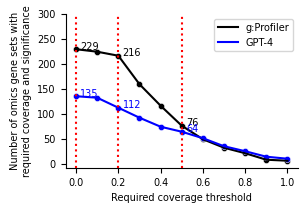

In [44]:
## plot coverage threshold curve
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2

save_plot_dir = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_coverage_thresh_coverage_curve.svg'
plot_thresholding_res(reduced_LLM_genes_by_coverage_DF, 
                      'gprofiler_coverage', 
                      'LLM_coverage',coverage_thresh_list = np.arange(0.0, 1.1, 0.1), 
                      enrich_adj_pval_thresh = adj_pval_thresh, 
                      LLM_score_thresh = LLM_score_thresh, 
                      highlight_coverage = [0.0, 0.2, 0.5])


# 2. Best APV

 - Select the best GO by the smallest p-value
 - Filter by p-value. 

If we later apply a coverage threshold to generate this curve, the curve will not change if the threshold is changed because the enriched term is not picked based on the coverage threshold

In [37]:
from utils.analyze_enrichment_utils import get_min_adj_p_value
%reload_ext autoreload
%autoreload 2

coverage_thresh = 0.2

# Grouping the DataFrame by the specified columns
grouped = merged_genes_DF.groupby(group_col)

# Apply the function to each group and reset the index
reduced_LLM_genes_APV_only_DF = grouped.apply(get_min_adj_p_value).reset_index(drop=True)


# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_APV_only_DF['LLM_success_TF'] = ((reduced_LLM_genes_APV_only_DF['Score'] >= LLM_score_thresh))
reduced_LLM_genes_APV_only_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_APV_only_DF['Adjusted P-value'] > adj_pval_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_APV_only_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_APV_only_DF, 5)
result_df


LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                   124    105    229
False                   11     60     71
Total                  135    165    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,True,True
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,defense response,GO:0006952,0.001123,15,1791,"1060P11.3,ADM,CAV2,CDC42EP3,CHST1,EMP1,IGF2BP3...",0.340909,0.13,0.008242,True,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,response to chemical,GO:0042221,0.005933,24,3957,"ABAT,ASS1,CHI3L1,CLDN3,GAL,PDE8B,TRD,TYMP,1060...",0.452830,NaN,0.006021,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,True


coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.2, enrichment: 163.0, LLM: 112.0
coverage threshold: 0.5, enrichment: 69.0, LLM: 64.0


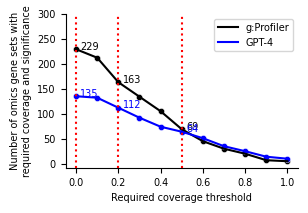

In [38]:
# plot thresholding curve
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2
save_plot_dir = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_coverage_curve.svg'
plot_thresholding_res(reduced_LLM_genes_APV_only_DF, 'gprofiler_coverage', 'LLM_coverage',coverage_thresh_list = np.arange(0.0, 1.1, 0.1), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.2, 0.5])

In [ ]:
# save 
reduced_LLM_genes_APV_only_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only.tsv", sep="\t", index=False)

# 2.1 Best APV with highest coverage

 - Select the best GO term by the smallest p-value
 -- If there are multiple GO terms with the same smallest p-value, then select the term with the highest coverage.
 - Filter by both the p-value and coverage thresholds. 


In [11]:
from utils.analyze_enrichment_utils import get_min_adj_p_value
%reload_ext autoreload
%autoreload 2

coverage_thresh = 0.2

# Grouping the DataFrame by the specified columns
grouped = merged_genes_DF.groupby(group_col)

# Apply the function to each group and reset the index
reduced_LLM_genes_APV_cover_thresh_DF = grouped.apply(lambda x: get_min_adj_p_value(x, sortCol='gprofiler_coverage')).reset_index(drop=True)


# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_APV_cover_thresh_DF['LLM_success_TF'] = ((reduced_LLM_genes_APV_cover_thresh_DF['Score'] >= LLM_score_thresh)& (reduced_LLM_genes_APV_cover_thresh_DF['LLM_coverage'] >= coverage_thresh)) # LLM creteria
reduced_LLM_genes_APV_cover_thresh_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_APV_cover_thresh_DF['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_APV_cover_thresh_DF['gprofiler_coverage'] < coverage_thresh)) # enrichment criteria


print(create_success_contingency_table(reduced_LLM_genes_APV_cover_thresh_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_APV_cover_thresh_DF, 5)
result_df


LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                    96     91    187
False                   16     97    113
Total                  112    188    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,True,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,response to stress,GO:0006950,0.001123,22,3855,"1060P11.3,ADM,CAV2,CDC42EP3,CHST1,EMP1,EXT1,NI...",0.500000,0.13,0.005674,False,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,developmental process,GO:0032502,0.005933,32,6453,"ABAT,ASS1,CHI3L1,CLDN3,FRZB,GAL,MAN2A1,NELL2,T...",0.603774,NaN,0.004943,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,True


coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.2, enrichment: 187.0, LLM: 112.0
coverage threshold: 0.5, enrichment: 86.0, LLM: 64.0


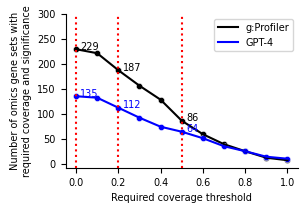

In [12]:
# plot
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2
save_plot_dir = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_cover_thresh_coverage_curve.svg'
plot_thresholding_res(reduced_LLM_genes_APV_cover_thresh_DF, 'gprofiler_coverage', 'LLM_coverage',coverage_thresh_list = np.arange(0.0, 1.1, 0.1), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.2, 0.5])

In [15]:
# # save the file
# reduced_LLM_genes_APV_cover_thresh_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02.tsv", sep="\t", index=False)
# # save the T/F, F/T and T/T separately
# reduced_LLM_genes_APV_cover_thresh_DF[(reduced_LLM_genes_APV_cover_thresh_DF['LLM_success_TF'] == True) & (reduced_LLM_genes_APV_cover_thresh_DF['gprofiler_success_TF'] == False)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02_llmT_goF.tsv", sep="\t", index=False)
# reduced_LLM_genes_APV_cover_thresh_DF[(reduced_LLM_genes_APV_cover_thresh_DF['LLM_success_TF'] == False) & (reduced_LLM_genes_APV_cover_thresh_DF['gprofiler_success_TF'] == True)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02_llmF_goT.tsv", sep="\t", index=False)

# # Calculated semantic similarity between LLM and gprofiler gene names by running "run_omics_sem_sim.py"
# # load the file with semantic similarity 
# sim_val_reduce_LLM_gnees_APV_cover_thresh_DF = pd.read_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02_simVals_DF.tsv", sep="\t")
# #sort 
# sim_val_reduce_LLM_gnees_APV_cover_thresh_DF.sort_values(by='LLM_name_GO_term_sim', ascending=False, inplace=True)
# sim_val_reduce_LLM_gnees_APV_cover_thresh_DF[(sim_val_reduce_LLM_gnees_APV_cover_thresh_DF['LLM_success_TF'] == True) & (sim_val_reduce_LLM_gnees_APV_cover_thresh_DF['gprofiler_success_TF'] == True)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_cover_thresh_02_llmT_goT.tsv", sep="\t", index=False)

# 2.2 Best APV with highest JI
 - Select the best GO term by the smallest p-value
 -  If there are multiple GO terms with the same smallest p-value, then pick the term with the highest JI.
 - Filter by both the p-value and JI thresholds.


In [72]:
from utils.analyze_enrichment_utils import get_min_adj_p_value
%reload_ext autoreload
%autoreload 2

# Grouping the DataFrame by the specified columns
grouped = merged_genes_DF.groupby(group_col)

# Apply the function to each group and reset the index
reduced_LLM_genes_APV_thred_JI_DF = grouped.apply(lambda x: get_min_adj_p_value(x, sortCol='gprofiler_JI')).reset_index(drop=True)


# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_APV_thred_JI_DF['LLM_success_TF'] = ((reduced_LLM_genes_APV_thred_JI_DF ['Score'] >= LLM_score_thresh)& (reduced_LLM_genes_APV_thred_JI_DF ['LLM_JI'] >= JI_thresh)) # LLM creteria
reduced_LLM_genes_APV_thred_JI_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_APV_thred_JI_DF ['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_APV_thred_JI_DF['gprofiler_JI'] < JI_thresh)) # enrichment criteria


print(create_success_contingency_table(reduced_LLM_genes_APV_thred_JI_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_APV_thred_JI_DF, 5)
result_df


LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                    33     51     84
False                   29    187    216
Total                   62    238    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,False,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,inflammatory response,GO:0006954,0.001123,11,829,"1060P11.3,ADM,CAV2,CDC42EP3,EMP1,LPAR6,TRIB2,A...",0.250000,0.13,0.012761,False,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,actomyosin structure organization,GO:0031032,0.005933,6,204,"AKR1B1,CAPN3,DKK1,MARCKS,MTUS1,OPN3",0.113208,NaN,0.023904,False,False
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,False


coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.05, enrichment: 84.0, LLM: 62.0
coverage threshold: 0.1, enrichment: 33.0, LLM: 42.0
coverage threshold: 0.2, enrichment: 4.0, LLM: 21.0
coverage threshold: 0.3, enrichment: 0.0, LLM: 13.0
coverage threshold: 0.5, enrichment: 0.0, LLM: 7.0


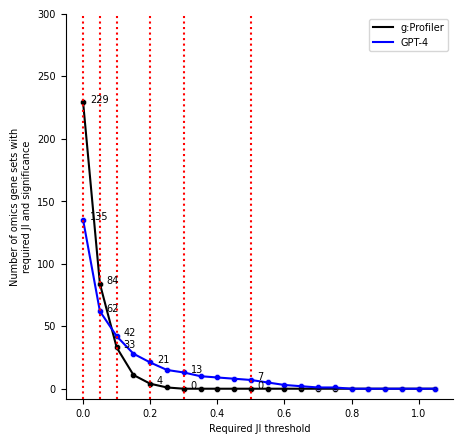

In [87]:
# plot thresholding curve
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2
save_plot_dir = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_JI_thresh_curve.svg'
plot_thresholding_res(reduced_LLM_genes_APV_thred_JI_DF, 'gprofiler_JI', 'LLM_JI',coverage_thresh_list = np.arange(0.0, 1.1, 0.05), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.05,0.1, 0.2,0.3, 0.5],figsize=(5,5), ax_label_keyword= 'JI')

In [ ]:
# # uncomment and save 
# reduced_LLM_genes_APV_thred_JI_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005.tsv", sep="\t", index=False)
# # save the T/F, F/T and T/T separately
# reduced_LLM_genes_APV_thred_JI_DF[(reduced_LLM_genes_APV_thred_JI_DF['LLM_success_TF'] == True) & (reduced_LLM_genes_APV_thred_JI_DF['gprofiler_success_TF'] == False)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005_llmT_goF.tsv", sep="\t", index=False)
# reduced_LLM_genes_APV_thred_JI_DF[(reduced_LLM_genes_APV_thred_JI_DF['LLM_success_TF'] == False) & (reduced_LLM_genes_APV_thred_JI_DF['gprofiler_success_TF'] == True)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005_llmF_goT.tsv", sep="\t", index=False)

# ### Calculated semantic similarity between LLM and gprofiler gene names by running "run_omics_sem_sim.py"
# sim_val_reduced_LLM_genes_APV_thred_JI_DF = pd.read_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005_simVals_DF.tsv", delimiter="\t")
# sim_val_reduced_LLM_genes_APV_thred_JI_DF.sort_values(by='LLM_name_GO_term_sim', ascending=False, inplace=True)

# sim_val_reduced_LLM_genes_APV_thred_JI_DF[(sim_val_reduced_LLM_genes_APV_thred_JI_DF['LLM_success_TF'] == True) & (sim_val_reduced_LLM_genes_APV_thred_JI_DF['gprofiler_success_TF'] == True)].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005_llmT_goT.tsv", sep="\t", index=False)

# 3.  Best coverage of those passing the p-value and coverage thresholds
 - Select the best GO term by highest coverage among the terms passing the p-value and coverage thresholds
 - Filter by both p-value and coverage thresholds to determine success vs not.

*Yields the SAME numbers as option #1 but selects different GO terms (prioritize coverage)*


In [34]:
from utils.analyze_enrichment_utils import filter_and_select_max_coverage
%reload_ext autoreload
%autoreload 2

grouped = merged_genes_DF.groupby(group_col)
reduced_LLM_genes_by_max_coverage_DF = grouped.apply(lambda x:filter_and_select_max_coverage(x, adj_pval_thresh, thresh=coverage_thresh)).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_by_max_coverage_DF['LLM_success_TF'] = ((reduced_LLM_genes_by_max_coverage_DF['Score'] >= LLM_score_thresh)& (reduced_LLM_genes_by_max_coverage_DF['LLM_coverage'] >= coverage_thresh)) # LLM creteria
reduced_LLM_genes_by_max_coverage_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_by_max_coverage_DF['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_by_max_coverage_DF['gprofiler_coverage'] < coverage_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_by_max_coverage_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_max_coverage_DF, 5)
result_df

LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                   103    113    216
False                    9     75     84
Total                  112    188    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,biological regulation,GO:0065007,0.029217,20,12680,"CITED2,COL5A1,CRABP2,KCTD12,MDFIC,MMP2,NRP1,OR...",0.909091,0.21,0.001577,True,True
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,biological regulation,GO:0065007,0.034641,36,12680,"1060P11.3,ADM,AHR,ARL4C,ATP10D,CAV2,CD44,CHST1...",0.818182,0.13,0.002837,False,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,response to stimulus,GO:0050896,0.007235,38,8976,"ABAT,ASS1,CHI3L1,CHST2,CLDN3,FRZB,GAL,PDE8B,TB...",0.716981,NaN,0.004226,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of cellular process,GO:0050794,0.043562,9,11738,"AMIGO2,AREG,GAS6,GPR37,IFT57,PELI1,SQLE,AKAP12...",1.000000,NaN,0.000767,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,regulation of biological process,GO:0050789,0.018778,14,12287,"1060P11.3,CPE,EFNB2,H2AC6,IL1R2,INHBB,LYPD1,NU...",1.000000,NaN,0.001139,False,True


# 4. Best APV of those meeting both JI and apv threshold
 - Select the best GO term by the smallest p-value among the terms passing p-value and JI thresholds
 - Filter by both the p-value and JI thresholds to determine success vs not.


In [7]:
from utils.analyze_enrichment_utils import filter_and_select_coverage
%reload_ext autoreload
%autoreload

JI_thresh = 0.1
grouped = merged_genes_DF.groupby(group_col)
# Grouping the DataFrame by the specified columns
reduced_LLM_genes_by_apv_JI_DF = grouped.apply(lambda x: filter_and_select_coverage(x, adj_pval_thresh, 'gprofiler_JI', thresh=JI_thresh)).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'enrichr_success_TF' columns
reduced_LLM_genes_by_apv_JI_DF['LLM_success_TF'] = (reduced_LLM_genes_by_apv_JI_DF['Score'] >= LLM_score_thresh) & (reduced_LLM_genes_by_apv_JI_DF['LLM_JI'] >= JI_thresh) # LLM creteria
reduced_LLM_genes_by_apv_JI_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_by_apv_JI_DF['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_by_apv_JI_DF['gprofiler_JI'] < JI_thresh))

print(create_success_contingency_table(reduced_LLM_genes_by_apv_JI_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_apv_JI_DF, 5)
result_df

LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                    22     45     67
False                   20    213    233
Total                   42    258    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,False,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,defense response,GO:0006952,0.001123,15,1791,"1060P11.3,ADM,CAV2,CDC42EP3,CHST1,EMP1,IGF2BP3...",0.340909,0.13,0.008242,False,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,response to chemical,GO:0042221,0.005933,24,3957,"ABAT,ASS1,CHI3L1,CLDN3,GAL,PDE8B,TRD,TYMP,1060...",0.452830,NaN,0.006021,False,False
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,False


coverage threshold: 0.0, enrichment: 229.0, LLM: 135.0
coverage threshold: 0.05, enrichment: 97.0, LLM: 62.0
coverage threshold: 0.1, enrichment: 67.0, LLM: 42.0


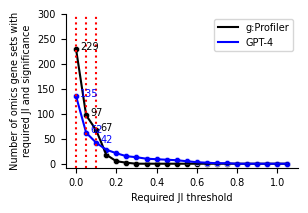

In [15]:
# plot thresholding curve
from utils.analyze_enrichment_utils import plot_thresholding_res
%reload_ext autoreload
%autoreload 2
save_plot_dir = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_JI_curve.svg'
plot_thresholding_res(reduced_LLM_genes_by_apv_JI_DF, 'gprofiler_JI', 'LLM_JI',coverage_thresh_list = np.arange(0.0, 1.1, 0.05), enrich_adj_pval_thresh = adj_pval_thresh, LLM_score_thresh = LLM_score_thresh, highlight_coverage = [0.0, 0.05, 0.1], ax_label_keyword='JI')

# 5. Best JI of those meeting both JI and apv threshold
- Select the best GO term by the highest JI among the terms passing both the p-value and JI thresholds
 - Filter by both the p-value and JI thresholds to determine success vs not.

Yields the SAME numbers as option #4, but selects different GO terms 


In [6]:
from utils.analyze_enrichment_utils import filter_and_select_max_coverage
%reload_ext autoreload
%autoreload 2

grouped = merged_genes_DF.groupby(group_col)
reduced_LLM_genes_by_max_JI_DF = grouped.apply(lambda x:filter_and_select_max_coverage(x, adj_pval_thresh, 'gprofiler_JI', thresh=JI_thresh)).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_by_max_JI_DF['LLM_success_TF'] = ((reduced_LLM_genes_by_max_JI_DF['Score'] >= LLM_score_thresh)& (reduced_LLM_genes_by_max_JI_DF['LLM_JI'] >= JI_thresh)) # LLM creteria

reduced_LLM_genes_by_max_JI_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_by_max_JI_DF['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_by_max_JI_DF['gprofiler_JI'] < JI_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_by_max_JI_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_max_JI_DF, 5)

result_df

LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                    22     45     67
False                   20    213    233
Total                   42    258    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,False,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,inflammatory response,GO:0006954,0.001123,11,829,"1060P11.3,ADM,CAV2,CDC42EP3,EMP1,LPAR6,TRIB2,A...",0.250000,0.13,0.012761,False,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,actomyosin structure organization,GO:0031032,0.005933,6,204,"AKR1B1,CAPN3,DKK1,MARCKS,MTUS1,OPN3",0.113208,NaN,0.023904,False,False
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,False


In [12]:
## if the Terms are the same
sum(reduced_LLM_genes_by_apv_JI_DF['Term'] != reduced_LLM_genes_by_max_JI_DF['Term'])

60

## Computing semantic similarity of GO term name and LLM name when both methods yield a name using run_omics_sem_sim.py

In [19]:
# load the semantic similarity
similarity_df = pd.read_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_reduce_APV_add_JI_thresh_005_simVals_DF.tsv", sep="\t")  
print(similarity_df.shape)
similarity_df.sort_values(by='LLM_name_GO_term_sim', ascending=False, inplace=True)
similarity_df.head(5)

(300, 31)


,Source,GeneSetID,GeneSetName,GeneList,updated GeneList,n_Genes,LLM Name,LLM Analysis,Score,Term,...,GenesMentionedInText,LLM_coverage,LLM_best_matching_GO,best_matching_GO_ID,best_matching_GO_term_genes,best_matching_GO_term_size,LLM_JI,LLM_success_TF,gprofiler_success_TF,LLM_name_GO_term_sim
56,NeST,Cluster1-21,Cluster1-21,AURKA CKAP5 TACC1 TACC2 YEATS4,AURKA CKAP5 TACC1 TACC2 YEATS4,5,Mitotic Spindle Assembly and Chromosome Segreg...,"1. AURKA, Aurora kinase A, is a serine/threoni...",0.92,mitotic spindle organization,...,5.0,0.80,mitotic spindle assembly,GO:0090307,MISP EML3 CEP192 ZNF207 RACGAP1 CHMP6 FLNA CHM...,73.0,0.051282,True,False,0.875087
125,NeST,Cluster2-202,Cluster2-202,BID CASP1 CYCS DAXX MAP2K4 MAPK1 MAPK8 PSME3 S...,BID CASP1 CYCS DAXX MAP2K4 MAPK1 MAPK8 PSME3 S...,10,Apoptotic Signaling Pathway,1. BID is a BH3-interacting domain death agoni...,0.92,apoptotic process,...,10.0,0.60,apoptotic signaling pathway,GO:0097190,SLC25A31 PLSCR3 MAEL STRADB ATP5IF1 SIAH1 CASP...,600.0,0.009934,False,False,0.845240
82,NeST,Cluster2-134,Cluster2-134,ABHD13 APLF APTX ATP23 CETN2 CHD1L EHF GADD45G...,ABHD13 APLF APTX ATP23 CETN2 CHD1L EHF GADD45G...,23,DNA Damage Response and Repair,"1. The proteins ABHD13, APLF, APTX, CHD1L, GAD...",0.92,DNA repair,...,21.0,0.43,DNA damage response,GO:0006974,MAEL PMS2 ALKBH8 TAF6L MACROD1 TWIST1 NFATC2 C...,879.0,0.011261,False,False,0.833955
107,NeST,Cluster2-173,Cluster2-173,ACAA1 ACOX1 C6orf226 CAT DDO DECR2 HSD17B4 PEX...,ACAA1 ACOX1 C6orf226 CAT DDO DECR2 HSD17B4 PEX...,13,Peroxisomal Biogenesis and Function,1. ACAA1 (Acetyl-CoA acyltransferase 1) and AC...,0.94,peroxisome organization,...,13.0,0.69,peroxisome membrane biogenesis,GO:0016557,PEX16 PEX11A,2.0,0.642857,True,True,0.817934
73,NeST,Cluster2-118,Cluster2-118,MAGEL2 SNX5 SNX6 SNX7 WASHC3 WDFY1,MAGEL2 SNX5 SNX6 SNX7 WASHC3 WDFY1,6,Endosomal Sorting and Trafficking,1. MAGEL2 is a member of the MAGE family and i...,0.91,endosomal transport,...,6.0,1.00,endosomal transport,GO:0016197,PICALM HOOK1 EPS15 ANXA8L1 MYO5B STX8 VPS11 CH...,289.0,0.020690,False,False,0.815202


(33, 31)


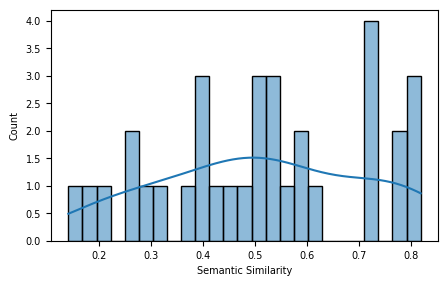

In [27]:
both_success = similarity_df[(similarity_df['LLM_success_TF'] == True) & (similarity_df['gprofiler_success_TF'] == True)]
print(both_success.shape)
# plot distribution of the similarity
plt.figure(figsize=(5,3))
sns.histplot(data=both_success, x='LLM_name_GO_term_sim', bins=25, kde=True)
plt.xlabel('Semantic Similarity')
plt.ylabel('Count')
plt.show()

## Select the tails of the distribution

In [35]:
# cases above vs below the threshold
similarity_thre = 0.5
print(both_success[both_success['LLM_name_GO_term_sim'] > similarity_thre].shape[0])
print(both_success[both_success['LLM_name_GO_term_sim'] <= similarity_thre].shape[0])

18
15


In [60]:
# any GO term with JI threshold >0.2?
similarity_df.loc[similarity_df['gprofiler_JI'] > 0.2,['n_Genes', 'GeneList', 'LLM Name', 'Score', 'Term', 'GO ID','LLM_name_GO_term_sim',
        'Adjusted P-value', 'intersection_size', 'term_size', 'intersections',  'gprofiler_coverage','LLM_coverage', 'gprofiler_JI', 'LLM_JI',
        'LLM_success_TF', 'gprofiler_success_TF']]


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,LLM_name_GO_term_sim,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_JI,LLM_success_TF,gprofiler_success_TF
123,8,FBXO45 HEY1 HEY2 HEYL NINL PAWR SPRYD3 THAP1,Regulation of transcription and cell signaling...,0.88,umbilical cord morphogenesis,GO:0036304,0.365624,0.000010,2,2,"HEY1,HEY2",0.285714,0.75,0.285714,0.002478,False,True
136,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,NaN,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,NaN,False,True


## Compare p:Profiler coverage vs LLM coverage and show semantic similarity

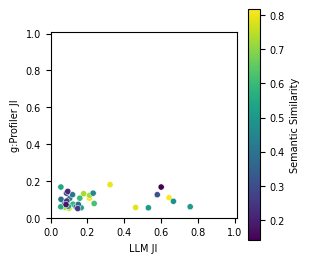

In [52]:
# LLM coverage vs gprofiler converage, colored by the similarity with countinuous color
plt.figure(figsize=(3,3))

y_field = 'gprofiler_JI'
y_label = 'g:Profiler JI'
x_field = 'LLM_JI'
x_label = 'LLM JI'


ax = sns.scatterplot(data=both_success, x=x_field, y=y_field, hue='LLM_name_GO_term_sim', palette='viridis',s = 20,legend=None)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.xlim(0,1.01)
plt.ylim(0,1.01)

# # Setting the aspect of the plot to be equal
ax.set_aspect('equal', adjustable='box')

# Create a colorbar
norm = plt.Normalize(both_success['LLM_name_GO_term_sim'].min(), both_success['LLM_name_GO_term_sim'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax, label='Semantic Similarity')

plt.show()



## Compare p:Profiler JI vs LLM JI and show semantic similarity

/tmp/ipykernel_3242979/2272817244.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Semantic Similarity')


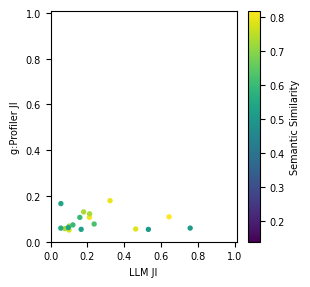

In [46]:


# Define the range of semantic similarity you're interested in
similarity_min = 0.5
similarity_max = 0.99

y_field = 'gprofiler_JI'
y_label = 'g:Profiler JI'
x_field = 'LLM_JI'
x_label = 'LLM JI'

# y_field = 'gprofiler_coverage'
# y_label = 'g:Profiler coverage'
# x_field = 'LLM_coverage'
# x_label = 'LLM coverage'

# Filter the DataFrame
filtered_data = both_success[(both_success['LLM_name_GO_term_sim'] >= similarity_min) &
                             (both_success['LLM_name_GO_term_sim'] <= similarity_max)]

# LLM JI vs gprofiler JI, colored by the similarity with countinuous color
plt.figure(figsize=(3,3))

# Full range normalization
full_range_norm = plt.Normalize(both_success['LLM_name_GO_term_sim'].min(), both_success['LLM_name_GO_term_sim'].max())

# Create the scatter plot using the filtered data with explicit normalization
# Here, we switch to using matplotlib directly
sc = plt.scatter(
    x=filtered_data[x_field], 
    y=filtered_data[y_field], 
    c=filtered_data['LLM_name_GO_term_sim'],  # Color by this column
    cmap='viridis',
    norm=full_range_norm,  # Explicitly use the full range for color normalization
    s=8  # Set the size of the points
)

plt.xlabel(x_label)
plt.ylabel(y_label)

plt.xlim(0, 1.01)
plt.ylim(0, 1.01)
# Setting the aspect of the plot to be equal
# plt.gca().set_aspect('equal', adjustable='box')


# Create a colorbar
#norm = plt.Normalize(both_success['LLM_name_GO_term_sim'].min(), both_success['LLM_name_GO_term_sim'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=full_range_norm)
sm.set_array([])

plt.colorbar(sm, label='Semantic Similarity')

plt.show()

In [41]:
both_success.loc[(both_success['LLM_name_GO_term_sim'] <= similarity_thre), ['n_Genes', 'GeneList', 'LLM Name', 'Score', 'Term', 'GO ID','LLM_name_GO_term_sim',
        'Adjusted P-value', 'intersection_size', 'term_size', 'intersections',  'gprofiler_coverage','LLM_coverage', 'gprofiler_JI', 'LLM_JI',
        'LLM_success_TF', 'gprofiler_success_TF']].sort_values(by='LLM_name_GO_term_sim', ascending=True)

,n_Genes,GeneList,LLM Name,Score,Term,GO ID,LLM_name_GO_term_sim,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_JI,LLM_success_TF,gprofiler_success_TF
66,16,ANKRD39 BTBD9 KCTD9 KCTD11 KLHL2 KLHL3 KLHL12 ...,Regulation of Cullin-RING Ubiquitin Ligase (CR...,0.85,negative regulation of pancreatic juice secretion,GO:0090188,0.140170,3.053437e-06,3,5,"WNK1,WNK3,WNK4",0.187500,0.75,0.166667,0.600000,True,True
26,29,1060P11.3 AEBP1 AMIGO2 CNPY3 FABP7 HMGCR HMGCS...,Cholesterol Biosynthesis and Regulation,0.85,positive regulation of aggrephagy,GO:1905337,0.179547,3.135453e-03,2,3,"APLP2,FERMT1",0.074074,0.14,0.071429,0.083333,True,True
90,6,ARHGAP21 CDC27 CTNNA2 HDAC1 SOX2 USP7,Regulation of Chromatin Structure and Cell Cyc...,0.85,myofibroblast cell apoptotic process,GO:1904516,0.218854,2.983027e-02,1,2,SOX2,0.166667,0.67,0.142857,0.093023,True,True
14,13,1060P11.3 ADIRF ENPP2 GJA1 HIST1H2AC HSPA6 IL1...,Stress Response and Inflammatory Signaling,0.85,maintenance of protein location in mast cell s...,GO:0033370,0.252331,2.434748e-02,1,1,MAN1A1,0.090909,0.38,0.090909,0.087719,True,True
65,5,IER2 KIAA1671 MAF MAP3K9 SLC7A11,Response to Oxidative Stress and Regulation of...,0.85,lens fiber cell differentiation,GO:0070306,0.255617,6.812846e-03,2,38,"MAF,SLC7A11",0.500000,1.00,0.050000,0.147059,True,True
63,14,CRHR1 CRIPAK DYRK4 RNF123 STIM1 STIM2 THBS3 TH...,Stress Response and Intracellular Signaling Mo...,0.85,activation of store-operated calcium channel a...,GO:0032237,0.280393,1.234827e-03,2,5,"DYRK4,RNF123",0.166667,0.36,0.133333,0.086207,True,True
99,11,ACVR2A ACVR2B AHSA1 ARAF CDC37L1 CHORDC1 HGH1 ...,Regulation of Signal Transduction and Protein ...,0.85,positive regulation of activin receptor signal...,GO:0032927,0.310186,1.599410e-03,2,7,"ACVR2A,ACVR2B",0.181818,1.00,0.125000,0.578947,True,True
37,12,AZGP1 MAP7 TOB1 COL4A1 COL4A2 CRABP1 EIF5A KCN...,Extracellular Matrix Organization and Cell Sig...,0.85,collagen-activated tyrosine kinase receptor si...,GO:0038063,0.376637,3.688854e-03,2,10,"COL4A1,COL4A2",0.166667,0.33,0.100000,0.056338,True,True
32,21,1060P11.3 AZGP1 CPB1 HMGCR HMGCS1 IDI1 INSIG1 ...,Cholesterol Biosynthesis and Regulation,0.85,secondary alcohol biosynthetic process,GO:1902653,0.384240,5.850783e-07,5,54,"CPB1,HMGCR,HMGCS1,IDI1,LDLR",0.250000,0.29,0.072464,0.150000,True,True
100,14,ALDOA ALDOC EEF1A2 GAPDHS GPI ISYNA1 LDHA LDHB...,Glycolysis and Gluconeogenesis Regulation,0.92,nicotinamide nucleotide metabolic process,GO:0046496,0.390926,1.383526e-16,10,166,"ALDOA,ALDOC,GAPDHS,GPI,LDHA,LDHB,PGAM1,PGAM4,P...",0.714286,0.64,0.058824,0.138462,True,True
